# Imports

In [45]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, Binarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from shapely.geometry import Point
from datetime import date
import matplotlib.pyplot as plt

# Load Precipitation Data

In [2]:
filepath = 'data/ky_prec_with_gps.csv'

cols = ['STATION', 'DATE', 'PRCP', 'LATITUDE', 'LONGITUDE']

dtypes = {
    'STATION': 'category',
    'DATE': 'string',
    'PRCP': 'float32',
    'LATITUDE': 'float32',
    'LONGITUDE': 'float32',
}

weather_df = pd.read_csv(filepath, dtype=dtypes, usecols=cols)

weather_df['DATE'] = pd.to_datetime(pd.Series(weather_df['DATE']), format='%Y-%m-%d', errors='coerce').dt.date
weather_df['PRCP'] = weather_df['PRCP'].fillna(0)
weather_df['PRCP'] = weather_df.PRCP.apply(lambda x: x * 100).apply(np.int32)

display(weather_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955383 entries, 0 to 1955382
Data columns (total 5 columns):
 #   Column     Dtype   
---  ------     -----   
 0   STATION    category
 1   LATITUDE   float32 
 2   LONGITUDE  float32 
 3   DATE       object  
 4   PRCP       int32   
dtypes: category(1), float32(2), int32(1), object(1)
memory usage: 41.1+ MB


None

In [3]:
display(weather_df.head(10))

,STATION,LATITUDE,LONGITUDE,DATE,PRCP
0,US1KYMS0002,38.532425,-83.754707,2009-04-17,0
1,US1KYMS0002,38.532425,-83.754707,2009-04-18,0
2,US1KYMS0002,38.532425,-83.754707,2009-04-19,30
3,US1KYMS0002,38.532425,-83.754707,2009-04-20,2029
4,US1KYMS0002,38.532425,-83.754707,2009-04-21,329
5,US1KYMS0002,38.532425,-83.754707,2009-04-22,129
6,US1KYMS0002,38.532425,-83.754707,2009-04-23,0
7,US1KYMS0002,38.532425,-83.754707,2009-04-24,0
8,US1KYMS0002,38.532425,-83.754707,2009-04-25,0
9,US1KYMS0002,38.532425,-83.754707,2009-04-26,0


# Load FEMA Project Data

In [4]:
filepath2 = 'data/PublicAssistanceFundedProjectsDetails.csv'

cols=[
    'disasterNumber',
    'stateCode',
    'countyCode',
    'county',
    'projectSize',
    'dcc',             # Determines if damage is Roads & Bridges
    'projectAmount'
]


dtypes={
    'disasterNumber': 'category',
    'county': 'category',
    'countyCode': 'category',
    'projectSize': 'category',
    'dcc': 'category',
    'stateCode': 'category',
    'projectAmount': 'float32'
}

df2 = pd.read_csv(filepath2, usecols=cols, dtype=dtypes)

# Filter and clean df2
filtered_df = df2[(df2.stateCode == 'KY') & (df2.dcc == 'C')].copy()
filtered_df['normalized_county'] = filtered_df['county'].str.replace(' County', '', regex=False).str.strip().str.title()

# Drop unnecessary columns
final_data = filtered_df.drop(labels=['stateCode', 'dcc', 'county'], axis=1)

display(final_data.info())
display(final_data.head(5))

# Get unique counties in sorted order
# unique_counties = final_data['county'].dropna().cat.remove_unused_categories()
# unique_counties = pd.DataFrame(sorted(unique_counties.unique()), columns=['Unique Counties'])
# print(unique_counties.to_string(index=False))



<class 'pandas.core.frame.DataFrame'>
Index: 15139 entries, 59 to 807119
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   disasterNumber     15139 non-null  category
 1   projectSize        15139 non-null  category
 2   countyCode         15139 non-null  category
 3   projectAmount      15139 non-null  float32 
 4   normalized_county  15137 non-null  object  
dtypes: category(3), float32(1), object(1)
memory usage: 458.1+ KB


None

,disasterNumber,projectSize,countyCode,projectAmount,normalized_county
59,4663,Small,133,535403.750000,Letcher
73,4711,Small,129,102442.460938,Lee
109,4663,Small,133,15449.780273,Letcher
112,4663,Small,133,6900.930176,Letcher
121,4711,Small,25,89828.742188,Breathitt


# Load FEMA Disaster Information Data

In [5]:
filepath3 = 'data/DisasterDeclarationsSummaries.csv'

cols=[
    'disasterNumber',
    'state',
    'designatedArea',
    'incidentBeginDate'
]


dtypes={
    'disasterNumber': 'category',
    'state': 'category',
    'designatedArea': 'category',
    'incidentBeginDate': 'string'  # Changed from datetime64[ns] to string
}

df3 = pd.read_csv(filepath3, usecols=cols, dtype=dtypes)
df3['incidentBeginDate'] = pd.to_datetime(df3['incidentBeginDate'])

# Filter and clean df3
filtered_ds = df3[df3.state == 'KY'].copy()
filtered_ds['normalized_county'] = filtered_ds['designatedArea'].str.replace(r'\s*\(County\)', '', regex=True).str.strip().str.title()

# Drop state and original designatedArea column
filtered_ds = filtered_ds.drop(labels=['state', 'designatedArea'], axis=1)

display(filtered_ds.info())
display(filtered_ds.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 3105 entries, 487 to 67861
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   disasterNumber     3105 non-null   category           
 1   incidentBeginDate  3105 non-null   datetime64[ns, UTC]
 2   normalized_county  3105 non-null   object             
dtypes: category(1), datetime64[ns, UTC](1), object(1)
memory usage: 247.4+ KB


None

,disasterNumber,incidentBeginDate,normalized_county
487,5166,2016-11-18 00:00:00+00:00,Harlan
488,5166,2016-11-18 00:00:00+00:00,Knox
489,5166,2016-11-18 00:00:00+00:00,Letcher
490,5166,2016-11-18 00:00:00+00:00,Pike
503,5158,2016-11-08 00:00:00+00:00,Breathitt


# Data mapping between disaster information and the incident date

In [6]:
incident_df = pd.merge(
    final_data,
    filtered_ds,
    how='inner',
    on=['disasterNumber', 'normalized_county']
)

# Optional: Rearrange columns for clarity
incident_df = incident_df[[
    'disasterNumber', 'normalized_county', 'countyCode',
    'projectSize', 'projectAmount', 'incidentBeginDate'
]]

# Display final merged result
display(incident_df.info())
display(incident_df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12956 entries, 0 to 12955
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   disasterNumber     12956 non-null  object             
 1   normalized_county  12956 non-null  object             
 2   countyCode         12956 non-null  category           
 3   projectSize        12956 non-null  category           
 4   projectAmount      12956 non-null  float32            
 5   incidentBeginDate  12956 non-null  datetime64[ns, UTC]
dtypes: category(2), datetime64[ns, UTC](1), float32(1), object(2)
memory usage: 403.0+ KB


None

,disasterNumber,normalized_county,countyCode,projectSize,projectAmount,incidentBeginDate
0,4663,Letcher,133,Small,535403.750000,2022-07-26 00:00:00+00:00
1,4711,Lee,129,Small,102442.460938,2023-02-15 00:00:00+00:00
2,4663,Letcher,133,Small,15449.780273,2022-07-26 00:00:00+00:00
3,4663,Letcher,133,Small,6900.930176,2022-07-26 00:00:00+00:00
4,4711,Breathitt,25,Small,89828.742188,2023-02-15 00:00:00+00:00
5,4804,Hopkins,107,Small,42995.929688,2024-05-21 00:00:00+00:00
6,4663,Perry,193,Small,42574.261719,2022-07-26 00:00:00+00:00
7,4663,Letcher,133,Small,20033.140625,2022-07-26 00:00:00+00:00
8,4804,Lyon,143,Small,18329.740234,2024-05-21 00:00:00+00:00
9,4663,Perry,193,Small,82297.390625,2022-07-26 00:00:00+00:00


# Geopandas

In [7]:
county_shp_filename = 'zip:data/cb_2018_us_county_500k.zip'
gdf_counties = gpd.read_file(county_shp_filename)

In [8]:
stations_list = 'data/ghcnd-stations.csv' #incorrect file

cols=[
    'STATION',
    'LATITUDE',
    'LONGITUDE',
]

dtypes = {
    'STATION': 'category',
    'LATITUDE': 'float32',
    'LONGITUDE': 'float32',
}

stations_df = pd.read_csv(stations_list, dtype=dtypes, usecols=cols)
display(stations_df.head(5))

,STATION,LATITUDE,LONGITUDE
0,ACW00011604,17.116699,-61.783298
1,ACW00011647,17.133301,-61.783298
2,AE000041196,25.333000,55.516998
3,AEM00041194,25.254999,55.363998
4,AEM00041217,24.433001,54.651001


In [9]:
gps = (38.532426, -83.754705)
point = Point(gps[1], gps[0])

county = gdf_counties[gdf_counties.geometry.contains(point)]
display(county)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
3125,21,161,00516924,0500000US21161,21161,Mason,06,621924068,16281864,"POLYGON ((-83.9916 38.5937, -83.96257 38.65396..."


In [10]:
# def get_gps_from_station(name):
#     station = stations_df[stations_df['STATION'] == name]
#     return (station['LATITUDE'], station['LONGITUDE'])

def get_county_from_gps(lat, long):
    point = Point(long, lat)
    county = gdf_counties[gdf_counties.geometry.contains(point)]
    return str(county['NAME'])

# Shorthand for the 2 above functions
def get_county_from_station(name):
    gps = get_gps_from_station(name)
    county = get_county_from_gps(gps[0], gps[1])
    return county

In [11]:
# Parital Test of grabbing county for stations
# part_weather_df = weather_df[weather_df['DATE'] >= date(2025,3,1)]
# counties = part_weather_df.apply(lambda x: get_county_from_gps(x['LATITUDE'], x['LONGITUDE']), axis=1)
# display(counties)

# Full
# weather_df['COUNTY'] = weather_df.apply(lambda x: get_county_from_gps(x['LATITUDE'], x['LONGITUDE']), axis=1)
# display(weather_df.info())

# Can probably be improved by doing only getting counties for unique stations then

df_unique_stations = weather_df[['STATION', 'LATITUDE', 'LONGITUDE']].drop_duplicates()

df_unique_stations['COUNTY'] = df_unique_stations.apply(lambda x: get_county_from_gps(x['LATITUDE'], x['LONGITUDE']), axis=1).astype('category')

weather_df_with_county = weather_df.merge(
    df_unique_stations[['STATION', 'COUNTY']],
    on='STATION',
    how='left'
)

display(weather_df_with_county.info())
display(weather_df_with_county.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955383 entries, 0 to 1955382
Data columns (total 6 columns):
 #   Column     Dtype   
---  ------     -----   
 0   STATION    category
 1   LATITUDE   float32 
 2   LONGITUDE  float32 
 3   DATE       object  
 4   PRCP       int32   
 5   COUNTY     category
dtypes: category(2), float32(2), int32(1), object(1)
memory usage: 44.8+ MB


None

,STATION,LATITUDE,LONGITUDE,DATE,PRCP,COUNTY
0,US1KYMS0002,38.532425,-83.754707,2009-04-17,0,"3125 Mason\nName: NAME, dtype: object"
1,US1KYMS0002,38.532425,-83.754707,2009-04-18,0,"3125 Mason\nName: NAME, dtype: object"
2,US1KYMS0002,38.532425,-83.754707,2009-04-19,30,"3125 Mason\nName: NAME, dtype: object"
3,US1KYMS0002,38.532425,-83.754707,2009-04-20,2029,"3125 Mason\nName: NAME, dtype: object"
4,US1KYMS0002,38.532425,-83.754707,2009-04-21,329,"3125 Mason\nName: NAME, dtype: object"


In [13]:
# Step 1: Load the county shapefile
county_gdf = gpd.read_file("zip://data/cb_2024_us_county_500k.zip")

# Step 2: Filter for Kentucky using the 'STATEFP' column (FIPS code for KY is '21')
kentucky_counties = county_gdf[county_gdf['STATEFP'] == '21']

# Step 3: Extract the relevant columns (county name, county code, state, and geometry)
result = kentucky_counties[['NAME', 'COUNTYFP', 'STATEFP', 'geometry']]

# Step 4: Rename the columns for better clarity
result = result.rename(columns={
    'NAME': 'county_name',
    'COUNTYFP': 'county_code',
    'STATEFP': 'state_code',
    'geometry': 'polygon'
})

# Step 5: Display the filtered data
print(result.head(5))

    county_name county_code state_code  \
44      Whitley         235         21   
50      Letcher         133         21   
181       Larue         123         21   
182     Johnson         115         21   
183     Jackson         109         21   

                                               polygon  
44   POLYGON ((-84.35585 36.81211, -84.35527 36.813...  
50   POLYGON ((-83.15345 36.95947, -83.15008 36.962...  
181  POLYGON ((-85.89446 37.47231, -85.89334 37.472...  
182  POLYGON ((-83.00349 37.86145, -83.00248 37.862...  
183  POLYGON ((-84.20429 37.50488, -84.20478 37.507...  


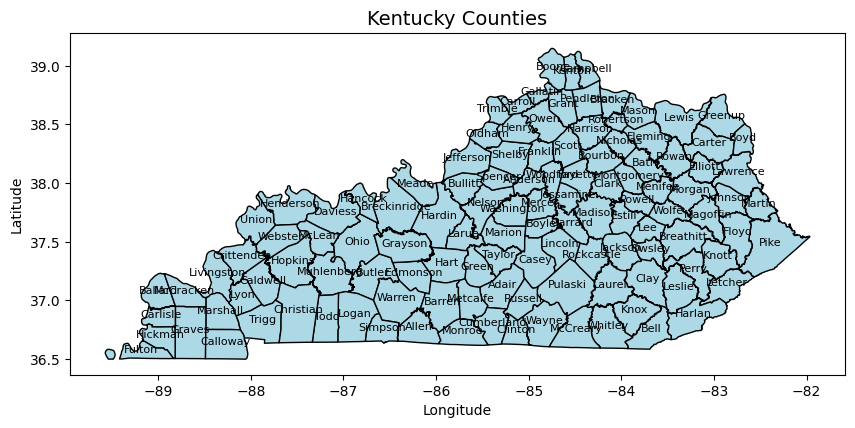

In [14]:
# Step 6: Plot the polygons (county boundaries) for Kentucky
fig, ax = plt.subplots(figsize=(10, 10))
kentucky_counties.plot(ax=ax, color='lightblue', edgecolor='black')

# Step 7: Add labels for county names (optional)
for idx, row in kentucky_counties.iterrows():
    ax.text(row['geometry'].centroid.x, row['geometry'].centroid.y, row['NAME'], fontsize=8, ha='center')

# Step 8: Find the county names
county_names = sorted(kentucky_counties['NAME'].unique().tolist())

# Step 9: Set title and labels
ax.set_title("Kentucky Counties", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

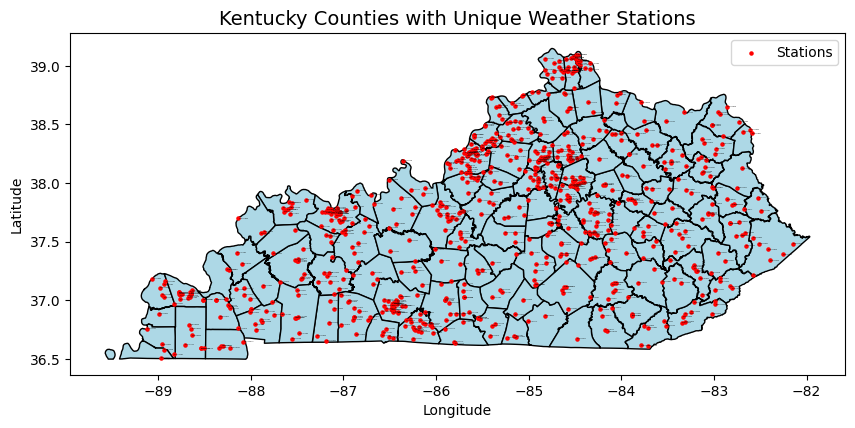

In [15]:
# Step 1: Load and filter the weather station data
stations_list = 'data/ky_prec_with_gps.csv'
cols = ['STATION', 'LATITUDE', 'LONGITUDE']
dtypes = {'STATION': 'category', 'LATITUDE': 'float32', 'LONGITUDE': 'float32'}
stations_df = pd.read_csv(stations_list, dtype=dtypes, usecols=cols)

# Step 2: Drop duplicate stations
stations_df_unique = stations_df.drop_duplicates(subset='STATION')

# Step 3: Convert to GeoDataFrame
stations_gdf = gpd.GeoDataFrame(
    stations_df_unique,
    geometry=[Point(xy) for xy in zip(stations_df_unique['LONGITUDE'], stations_df_unique['LATITUDE'])],
    crs="EPSG:4326"
)

# Step 4: Plot counties and filtered stations
fig, ax = plt.subplots(figsize=(10, 10))
kentucky_counties.plot(ax=ax, color='lightblue', edgecolor='black')
stations_gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Stations')

# Optional: Label station names
for idx, row in stations_gdf.iterrows():
    ax.text(row.geometry.x, row.geometry.y, row.STATION, fontsize=1, ha='left')

ax.set_title("Kentucky Counties with Unique Weather Stations", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [16]:
# Step 1: Convert to GeoDataFrame
stations_gdf = gpd.GeoDataFrame(
    stations_df_unique,
    geometry=[Point(xy) for xy in zip(stations_df_unique['LONGITUDE'], stations_df_unique['LATITUDE'])],
    crs="EPSG:4326"
)

# Step 2: Spatial join to find which station is in which county
joined = gpd.sjoin(stations_gdf, kentucky_counties, how="inner", predicate='within')

# Step 3: Build final table with desired columns
county_Weather_station = joined[['NAME', 'COUNTYFP', 'STATION']].rename(columns={
    'NAME': 'county_name',
    'COUNTYFP': 'county_code',
    'STATION': 'weather_station'
}).sort_values(by=['county_name', 'weather_station'])

# Display the first few rows of the table
print(county_Weather_station.head(10))

        county_name county_code weather_station
1000622       Adair         001     USC00151725
1260533       Adair         001     US1KYAD0001
1258646       Adair         001     US1KYAD0003
175479        Allen         003     US1KYAL0001
172563        Allen         003     US1KYAL0003
193448        Allen         003     US1KYAL0004
192610        Allen         003     US1KYAL0005
191911        Allen         003     US1KYAL0006
191754        Allen         003     US1KYAL0007
1220383       Allen         003     USC00157215


/var/folders/47/_9r2mr6j6j9fkf6b99yf8mt40000gn/T/ipykernel_95710/3650644755.py:9: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  joined = gpd.sjoin(stations_gdf, kentucky_counties, how="inner", predicate='within')


# Map the weather stations to the counties

In [17]:
# Make sure STATION types match
county_Weather_station['weather_station'] = county_Weather_station['weather_station'].astype(str)
weather_df['STATION'] = weather_df['STATION'].astype(str)

# Merge precipitation data with county weather station info
weather_df_with_county = weather_df.merge(
    county_Weather_station,
    left_on='STATION',
    right_on='weather_station',
    how='inner'
)

# Group by county and date
prcp_by_county = weather_df_with_county.groupby(['county_name', 'DATE'])['PRCP'].mean().reset_index()

# Rename for clarity
prcp_by_county.rename(columns={
    'county_name': 'County',
    'DATE': 'DATE',
    'PRCP': 'MEAN_PRCP'
}, inplace=True)

# Round to 1 decimal place
prcp_by_county['MEAN_PRCP'] = prcp_by_county['MEAN_PRCP'].round(1)

# Show final precipitation by county and date
display(prcp_by_county.head(1000))



,County,DATE,MEAN_PRCP
0,Adair,1998-01-01,0.0
1,Adair,1998-01-02,0.0
2,Adair,1998-01-03,0.0
3,Adair,1998-01-04,0.0
4,Adair,1998-01-05,0.0
...,...,...,...
995,Adair,2000-09-22,0.0
996,Adair,2000-09-23,0.0
997,Adair,2000-09-24,200.0
998,Adair,2000-09-25,559.0


# Map Disaster Data from Across Kentucky Counties

In [18]:
# Normalize the incident date to match weather DATE
incident_df['incident_date'] = pd.to_datetime(incident_df['incidentBeginDate']).dt.date

# Normalize county name in prcp data to title case
prcp_by_county['County'] = prcp_by_county['County'].str.strip().str.title()

# Merge on county and date
disaster_with_precip = pd.merge(
    prcp_by_county,
    incident_df,
    how='left',
    right_on=['normalized_county', 'incident_date'],
    left_on=['County', 'DATE']
)

display(disaster_with_precip.info())
display(disaster_with_precip.head(1000))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947760 entries, 0 to 947759
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   County             947760 non-null  object             
 1   DATE               947760 non-null  object             
 2   MEAN_PRCP          947760 non-null  float64            
 3   disasterNumber     10589 non-null   object             
 4   normalized_county  10589 non-null   object             
 5   countyCode         10589 non-null   category           
 6   projectSize        10589 non-null   category           
 7   projectAmount      10589 non-null   float32            
 8   incidentBeginDate  10589 non-null   datetime64[ns, UTC]
 9   incident_date      10589 non-null   object             
dtypes: category(2), datetime64[ns, UTC](1), float32(1), float64(1), object(5)
memory usage: 57.0+ MB


None

,County,DATE,MEAN_PRCP,disasterNumber,normalized_county,countyCode,projectSize,projectAmount,incidentBeginDate,incident_date
0,Adair,1998-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,Adair,1998-01-02,0.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,Adair,1998-01-03,0.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,Adair,1998-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,Adair,1998-01-05,0.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...
995,Adair,2000-09-22,0.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
996,Adair,2000-09-23,0.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
997,Adair,2000-09-24,200.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN
998,Adair,2000-09-25,559.0,NaN,NaN,NaN,NaN,NaN,NaT,NaN


# Compiling training data

In [19]:
disaster_with_precip['projectAmount'] = disaster_with_precip['projectAmount'].fillna(0.0)

# Uncomment only for testing purposes
# disaster_with_precip = disaster_with_precip[disaster_with_precip['projectAmount'] > 0.0]
# disaster_with_precip = disaster_with_precip[disaster_with_precip['MEAN_PRCP'] == 0.0]

Training_output = disaster_with_precip.groupby(
    ['County', 'DATE', 'MEAN_PRCP']
)['projectAmount'].sum().reset_index()

# Keep only the specified 4 columns (dropping the rest)
Training_output = Training_output[['County', 'DATE', 'MEAN_PRCP', 'projectAmount']]

# Exclude rows where MEAN_PRCP is 0.0 and projectAmount > 0.0
# Training_output = Training_output[
#     ~((Training_output['MEAN_PRCP'] == 0.0) & (Training_output['projectAmount'] > 0.0))
# ]

print("Result count:", len(Training_output))
display(Training_output.info())
display(Training_output.head(1000))


Result count: 937807
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937807 entries, 0 to 937806
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   County         937807 non-null  object 
 1   DATE           937807 non-null  object 
 2   MEAN_PRCP      937807 non-null  float64
 3   projectAmount  937807 non-null  float32
dtypes: float32(1), float64(1), object(2)
memory usage: 25.0+ MB


None

,County,DATE,MEAN_PRCP,projectAmount
0,Adair,1998-01-01,0.0,0.0
1,Adair,1998-01-02,0.0,0.0
2,Adair,1998-01-03,0.0,0.0
3,Adair,1998-01-04,0.0,0.0
4,Adair,1998-01-05,0.0,0.0
...,...,...,...,...
995,Adair,2000-09-22,0.0,0.0
996,Adair,2000-09-23,0.0,0.0
997,Adair,2000-09-24,200.0,0.0
998,Adair,2000-09-25,559.0,0.0


In [46]:
# Aggregate By County and Day
# prcp_by_county = weather_df_with_county.groupby(['COUNTY','DATE'])['PRCP'].mean().reset_index()
# prcp_by_county.rename(columns={'PRCP': 'MEAN_PRCP'}, inplace=True)

# prcp_by_county[prcp_by_county['MEAN_PRCP'].isnull()]

# Preprocessing

In [48]:
# display(Training_output.info())

X = Training_output.drop(columns=['projectAmount'])
# y = Training_output['projectAmount']

enc = OrdinalEncoder()
enc.fit(X[['County']])
X['County'] = enc.transform(X[['County']])

scaler_X = MinMaxScaler()
X['MEAN_PRCP'] = scaler_X.fit_transform(X[['MEAN_PRCP']])

binarizer_y = Binarizer(threshold=0.0)
y_binary = binarizer_y.fit_transform(Training_output[['projectAmount']])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.3, random_state=42)

# Training

In [49]:
log_reg_model = LogisticRegression(random_state=0)

log_reg_model.fit(X_train, y_train)

TypeError: float() argument must be a string or a real number, not 'datetime.date'

# Visualizations/EDA

In [ ]:
df = pd.read_csv("data/ky_prec_with_gps.csv")

# Ensure data types are correct
df['PRCP'] = pd.to_numeric(df['PRCP'], errors='coerce')
df = df.dropna(subset=['LATITUDE', 'LONGITUDE', 'PRCP'])

# Group by station to get mean precipitation per station
station_data = df.groupby(['STATION', 'LATITUDE', 'LONGITUDE']).agg({'PRCP': 'mean'}).reset_index()

# Normalize precipitation
scaler = MinMaxScaler()
station_data['PRCP_scaled'] = scaler.fit_transform(station_data[['PRCP']])

# Plotting
plt.figure(figsize=(12, 8))
scatter = plt.scatter
(
    station_data['LONGITUDE'],
    station_data['LATITUDE'],
    c=station_data['PRCP'],
    s=station_data['PRCP_scaled'] * 200 + 10,  
    cmap='Blues',
    alpha=0.6,
    edgecolors='k'
)

plt.colorbar(scatter, label='Average Precipitation')
plt.title("Weather Stations: Precipitation vs. Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
prcp_df = pd.read_csv("sample_data/ky_prec_with_gps.csv")
prcp_df['PRCP'] = pd.to_numeric(prcp_df['PRCP'], errors='coerce')
prcp_df = prcp_df.dropna(subset=['LATITUDE', 'LONGITUDE', 'PRCP'])

# Average precipitation per station
prcp_grouped = prcp_df.groupby(['STATION', 'LATITUDE', 'LONGITUDE']).agg({'PRCP': 'mean'}).reset_index()

# Normalize precip like above graph
prcp_scaler = MinMaxScaler()
prcp_grouped['PRCP_scaled'] = prcp_scaler.fit_transform(prcp_grouped[['PRCP']])

# Load temperature data
temp_df = pd.read_csv("sample_data/ky_temperature.csv")
temp_df[['TMAX', 'TMIN']] = temp_df[['TMAX', 'TMIN']].apply(pd.to_numeric, errors='coerce')
temp_df = temp_df.dropna(subset=['LATITUDE', 'LONGITUDE', 'TMAX', 'TMIN'])

# Average temperature per station (still in Celsius)
temp_df.loc[:, 'TAVG'] = (temp_df['TMAX'] + temp_df['TMIN']) / 2
temp_grouped = temp_df.groupby(['STATION', 'LATITUDE', 'LONGITUDE']).agg({'TAVG': 'mean'}).reset_index()

# Merge both datasets on station coordinates
merged = pd.merge(prcp_grouped, temp_grouped, on=['STATION', 'LATITUDE', 'LONGITUDE'])

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    merged['LONGITUDE'],
    merged['LATITUDE'],
    s=merged['PRCP_scaled'] * 300 + 20,  # Dot size: precipitation
    c=merged['TAVG'],                   # Dot color: temperature
    cmap='OrRd',                        # Light to dark orange-red
    alpha=0.8,
    edgecolors='k'
)

plt.colorbar(scatter, label='Average Temperature (°F)')
plt.title("KY Weather Stations: Precipitation (Size) & Temperature (Color, °F)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()